# BBO-Rietveld DSMO

In this notebook, you can see how to automate Rietveld refinement with black-box optimization.  
Run the following cells to run the optimization.

## Documentations
- [JupyterLab](https://jupyterlab.readthedocs.io/en/stable/)
- [GSASIIscriptable: Scripting Interface](https://gsas-ii.readthedocs.io/en/latest/GSASIIscriptable.html)
- [Optuna](https://optuna.readthedocs.io/en/stable/)

In [1]:
# import packages

import os
import sys
from multiprocessing import Process, Queue
import pandas as pd
import optuna
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from dataclasses import dataclass
sys.path.append('/root/g2full/GSASII/')


/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Configurations
RANDOM_SEED = 1024
STUDY_NAME = 'DSMO'
DATA_DIR = 'data/' + STUDY_NAME
# all output files include GSAS project file (*.gpx) will be saved in WORK_DIR
WORK_DIR = 'work/' + STUDY_NAME

In [3]:
# make directories
! rm -f $WORK_DIR/*
! mkdir -p $WORK_DIR

In [4]:
@dataclass
class ProjectConfig:
    work_dir: str
    random_seed: int
    data_dir: str
    init_gpx_file: str
    two_t_min: int
    two_t_max: int
    
class Project:
    def __init__(self, config: ProjectConfig, trial_number: int):
        import GSASIIscriptable as G2sc
        import shutil

        # Create a project with a default project name
        shutil.copyfile(os.path.join(config.data_dir, config.init_gpx_file),
                        os.path.join(config.work_dir, f'project_seed{config.random_seed}_trial_{trial_number}.gpx'))
        self.gpx = G2sc.G2Project(gpxfile=os.path.join(
            config.work_dir, f'project_seed{config.random_seed}_trial_{trial_number}.gpx'))

        # Add two histograms to the project
        self.hist1 = self.gpx.histograms()[0]
        self.phase0 = self.gpx.phases()[0]
        self.hist1.data['Instrument Parameters'][0]['I(L2)/I(L1)'] = [0.5, 0.5, 0]

        # Set to use iso
        for val in self.phase0.data['Atoms']:
            val[9] = 'I'

    def refine_and_calc_Rwp(self, param_dict):
        self.gpx.do_refinements([param_dict])
        for hist in self.gpx.histograms():
            _, Rwp = hist.name, hist.get_wR()
        return Rwp

In the objective function, first, configurations for the following parameters are sampled.
Then, the crystal structure is refined by GSAS-II.
Finally, the calculated Rwp is returned.

| Parameter                                 | Parameter type   | Search space                                                                                                      |
|-------------------------------------------|------------------|-------------------------------------------------------------------------------------------------------------------|
| initial 2theta bound refinement           | categorical      | {True, False}                                                                                                      |
| initial 2theta lower bound (deg.)         | real             | [15, 80]                                                                                                          |
| initial 2theta upper bound (deg.)         | real/conditional | [l + 20, 100] (l is the initial 2theta lower bound)                                                                |
| background function                       | categorical      | {Chebyshev, cosine, Q^2 power series, Q^-2 power series, linear interpolate, inverse interpolate, log interpolate} |
| degree of background function             | initegral        | [1, 15]                                                                                                            |
| instrument zero position refinement       | categorical      | {True, False}                                                                                                      |
| sample shift X refinement                 | categorical      | {True, False}                                                                                                      |
| sample shift Y refinement                 | categorical      | {True, False}                                                                                                      |
| scale factor refinement                   | categorical      | {True, False}                                                                                                      |
| peak shape refinement (Gaussian: U, V, W) | categorical      | {True, False}                                                                                                      |
| peak shape refinement (Lorentzian: X, Y)  | categorical      | {True, False}                                                                                                      |
| peak shape refinement (SH/L)              | categorical      | {True, False}                                                                                                      |

In [5]:
def objective(trial, config):
    """
    objective function for Optuna.
    
    You can apply black-box optimization for other data analysis 
    by modifying this function for that task.
    
    Parameters
    ----------
    trial : optuna.trial object

    Returns
    -------
    Rwp : float
    
    """
    
    ### define search space ###
    # Limits (acute angle)
    limits_lb = trial.suggest_float('Limits lower bound', config.two_t_min, config.two_t_max- 20)
    limits_ub = trial.suggest_float('Limits upper bound', limits_lb + 20, config.two_t_max)
    limits_refine = trial.suggest_categorical('limits refine', [True, False])
    refdict0 = {'set': {'Limits': [limits_lb, limits_ub]}, 'refine': limits_refine}

    # Background
    background_type = trial.suggest_categorical(
        'Background type', ['chebyschev',
                            'cosine',
                            'Q^2 power series',
                            'Q^-2 power series',
                            'lin interpolate',
                            'inv interpolate',
                            'log interpolate'])
    no_coeffs = trial.suggest_int('Number of coefficients', 1, 15)  # [1, 15]
    background_refine = trial.suggest_categorical('Background refine', [True, False])
    refdict0bg_h = {
        'set': {
            'Background': {
                'type': background_type,
                'no. coeffs': no_coeffs,
                'refine': background_refine
            }
        }
    }

    # Instrument parameters
    instrument_parameters1_refine = []
    for p in ['Zero']:
        if trial.suggest_categorical('Instrument_parameters refine %s' % (p), [True, False]):
            instrument_parameters1_refine.append(p)
    refdict1_h = {'set': {'Cell': True, 'Instrument Parameters': instrument_parameters1_refine}}

    sample_parameters1_refine =[]
    for p in ['DisplaceX', 'DisplaceY', 'Scale']:
        if trial.suggest_categorical('Sample_parameters refine %s' % (p), [True, False]):
            sample_parameters1_refine.append(p)
    refdict1_h2 = {"set": {'Sample Parameters':sample_parameters1_refine }}

    instrument_parameters2_refine = []
    for p in ['U', 'V', 'W', 'X', 'Y', 'SH/L']:
        if trial.suggest_categorical('Peakshape_parameters refine %s' % (p), [True, False]):
            instrument_parameters2_refine.append(p)
    refdict2_h = {'set': {'Instrument Parameters': instrument_parameters2_refine}}

    refdict3_h = {'set': {'Atoms': {'all': 'XU'}}}

    # Limits (wide angle)
    refdict_fin_h = {'set': {'Limits': [config.two_t_min, config.two_t_max]}, 'refine': True}

    # Evaluate
    refine_params_list = [refdict0,
                          refdict0bg_h,
                          refdict1_h,
                          refdict1_h2,
                          refdict2_h,
                          refdict3_h,
                          refdict_fin_h]
    q_Rwp = Queue()
    
    ERROR_PENALTY = 1e9
    def evaluate(config, trial_number, refine_params_list, q_Rwp):
        try:
            print(config)
            print(trial_number)
            print(refine_params_list)
            project = Project(config, trial_number)
            for params in refine_params_list:
                Rwp = project.refine_and_calc_Rwp(params)                    
            # validate Uiso >= 0
            phase_Y2O3 = project.gpx.phases()[0]
            u_iso_list = [atom.uiso for atom in phase_Y2O3.atoms()]
            if min(u_iso_list) < 0:
                # Uiso < 0
                Rwp = ERROR_PENALTY
            q_Rwp.put(Rwp)
            
            # # CIF export
            # exported_cif_path = os.path.join(config.WORK_DIR, project_name+“.cif”)
            # phase.export_CIF(exported_cif_path, quickmode=True)
            
        except Exception as e:
            # Refinement failed
            print(e, file=sys.stderr)
            q_Rwp.put(ERROR_PENALTY)
            
    p = Process(target=evaluate, args=(config, trial.number, refine_params_list, q_Rwp))
    p.start()
    Rwp = ERROR_PENALTY
    try:
            Rwp = q_Rwp.get(timeout=30)
    except Exception as e:
        print(f"Error getting Rwp value: {e}")
    finally:
        p.terminate()
    
    return Rwp


In [6]:
config = ProjectConfig(
    work_dir=WORK_DIR,
    random_seed=RANDOM_SEED,
    data_dir=DATA_DIR,
    init_gpx_file='DSMO_init.gpx',
    two_t_min=15,
    two_t_max=100
)

In [7]:
study = optuna.create_study(study_name=STUDY_NAME + '_seed%s' % (RANDOM_SEED),
                            storage=f"sqlite:///{config.work_dir}/history_sqlite.db", 
                            load_if_exists=True,
                            sampler=optuna.samplers.TPESampler(n_startup_trials=20, seed=RANDOM_SEED))

[I 2024-10-19 04:51:19,240] A new study created in RDB with name: DSMO_seed1024


Run 200 refinements to find the best configuration. It may take abount an hour to complete.

In [ ]:
# Optimize
study.optimize(func=lambda trial: objective(trial, config), n_trials=100)

In [9]:
# Results
df = study.trials_dataframe()
df.columns = [''.join(col).replace('params', '').strip() for col in df.columns.values]
df.rename(columns={'value':'Rwp', 'number':'trial'}, inplace=True)
df.sort_values('Rwp')

,trial,Rwp,datetime_start,datetime_complete,duration,_Background refine,_Background type,_Instrument_parameters refine Zero,_Limits lower bound,_Limits upper bound,...,_Peakshape_parameters refine U,_Peakshape_parameters refine V,_Peakshape_parameters refine W,_Peakshape_parameters refine X,_Peakshape_parameters refine Y,_Sample_parameters refine DisplaceX,_Sample_parameters refine DisplaceY,_Sample_parameters refine Scale,_limits refine,state
94,94,9.791863e+00,2024-10-19 05:04:19.757359,2024-10-19 05:04:24.929190,0 days 00:00:05.171831,True,log interpolate,True,44.614140,95.005789,...,False,False,True,False,True,False,False,False,True,COMPLETE
95,95,9.792043e+00,2024-10-19 05:04:24.949055,2024-10-19 05:04:29.960834,0 days 00:00:05.011779,True,log interpolate,True,44.975149,95.163667,...,False,False,True,False,True,False,False,False,True,COMPLETE
98,98,9.792787e+00,2024-10-19 05:05:05.265765,2024-10-19 05:05:10.187675,0 days 00:00:04.921910,True,log interpolate,True,49.134212,95.810366,...,False,False,True,False,True,False,False,False,True,COMPLETE
91,91,9.793261e+00,2024-10-19 05:04:04.669453,2024-10-19 05:04:09.721549,0 days 00:00:05.052096,True,log interpolate,True,44.112789,95.076868,...,False,False,True,False,True,False,False,False,True,COMPLETE
89,89,9.793542e+00,2024-10-19 05:03:54.473834,2024-10-19 05:03:59.550053,0 days 00:00:05.076219,True,log interpolate,True,39.095937,94.360892,...,False,False,True,False,True,False,False,False,True,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,60,1.000000e+09,2024-10-19 04:59:37.710117,2024-10-19 05:00:07.851906,0 days 00:00:30.141789,False,Q^2 power series,False,72.170030,98.917139,...,True,True,True,False,False,False,True,False,True,COMPLETE
61,61,1.000000e+09,2024-10-19 05:00:07.871389,2024-10-19 05:00:11.860789,0 days 00:00:03.989400,True,log interpolate,True,77.557275,99.576723,...,False,False,True,False,True,False,True,False,True,COMPLETE
64,64,1.000000e+09,2024-10-19 05:00:20.001653,2024-10-19 05:00:50.144171,0 days 00:00:30.142518,True,Q^-2 power series,True,75.745877,99.892355,...,False,False,True,False,True,False,True,False,True,COMPLETE
40,40,1.000000e+09,2024-10-19 04:57:23.858229,2024-10-19 04:57:27.856080,0 days 00:00:03.997851,True,log interpolate,True,68.527934,92.795688,...,False,False,True,False,True,True,True,False,True,COMPLETE


In [10]:
# Best configuration
study.best_params

{'Limits lower bound': 44.61414038646587,
 'Limits upper bound': 95.00578883979328,
 'limits refine': True,
 'Background type': 'log interpolate',
 'Number of coefficients': 15,
 'Background refine': True,
 'Instrument_parameters refine Zero': True,
 'Sample_parameters refine DisplaceX': False,
 'Sample_parameters refine DisplaceY': False,
 'Sample_parameters refine Scale': False,
 'Peakshape_parameters refine U': False,
 'Peakshape_parameters refine V': False,
 'Peakshape_parameters refine W': True,
 'Peakshape_parameters refine X': False,
 'Peakshape_parameters refine Y': True,
 'Peakshape_parameters refine SH/L': False}

In [11]:
# Best Rwp
study.best_value

9.791862962698218

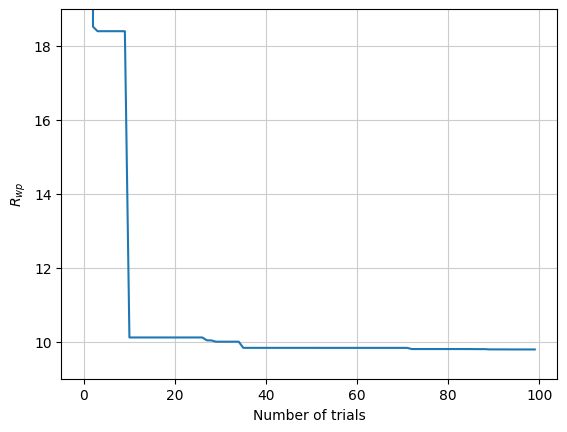

In [12]:
# Rwp plot
def rwp_plot():
    minvalues = [df.iloc[0]['Rwp']]
    for i in range(1, df.shape[0]):
        minvalues.append(min(minvalues[-1], df.iloc[i]['Rwp']))
    minvalues = pd.DataFrame(minvalues)
    
    minvalues.plot(legend=None)
    plt.ylim([9, 19])
    plt.grid(color='#cccccc')
    plt.ylabel('$R_{wp}$')
    plt.xlabel('Number of trials')
    plt.show()
    
rwp_plot()

Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist


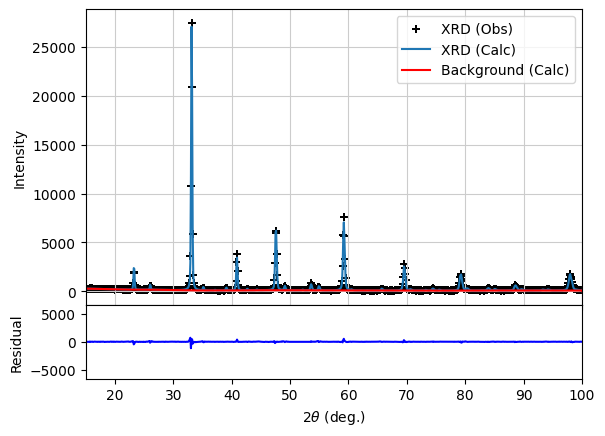

In [13]:
# Rietveld plot
def rietveld_plot():
    import GSASIIscriptable as G2sc

    gpx = G2sc.G2Project(
        f'{WORK_DIR}/project_seed{RANDOM_SEED}_trial_{study.best_trial.number}.gpx')

    hist1 = gpx.histograms()[0]
    phase0 = gpx.phases()[0]

    hist = hist1
    i = 5
    two_theta = hist.getdata("X")[::i]
    Yobs = hist.getdata("Yobs")[::i]
    Ycalc = hist.getdata("Ycalc")[::i]
    bg = hist.getdata("Background")[::i]
    residual = hist.getdata("Residual")[::i]

    fig = plt.figure()
    gs = GridSpec(5, 1, figure=fig)
    ax1 = fig.add_subplot(gs[:4, :])
    ax2 = fig.add_subplot(gs[4, :])
    fig.subplots_adjust(hspace=0)
    ax1.grid(color='#cccccc')

    ax1.scatter(two_theta, Yobs, marker='P', lw=0.0001, c='Black', label='XRD (Obs)')
    ax1.plot(two_theta, Ycalc, label='XRD (Calc)')
    ax1.plot(two_theta, bg, color='red', label='Background (Calc)')
    ax1.set_ylabel('Intensity')
    ax1.legend()
    ax2.plot(two_theta, residual, color='blue')
    plt.setp(ax1.get_xticklabels(), visible=False);
    ax2.set_ylim(-6600, 6600)
    plt.xlabel(r'$2\theta$ (deg.)')
    ax2.set_ylabel('Residual')
    ax1.set_xlim(config.two_t_min, config.two_t_max)
    ax2.set_xlim(config.two_t_min, config.two_t_max)
    plt.show()
    
rietveld_plot()